In [30]:
from sage.symbolic.expression import Expression
from sage.all import CC, RR
from sage.symbolic.relation import solve
from sage.plot.scatter_plot import scatter_plot
from sage.plot.point import points
from typing import List
import numpy as np

In [31]:
class LefschetzFibration:
    def __init__(self, variables: List[Expression], domain_eq: Expression, fibration_eq: Expression) -> None:
        self.variables = variables
        self.domain = domain_eq
        self.fibration = fibration_eq
    
    def __call__(self, argument):
        return self.fibration.subs(argument) 
    
    def get_critical_points(self):
        """Returns the set of critical points."""
        G = self.domain
        f = self.fibration
        a = self.variables[-1]
        variables = self.variables[:-1]

        constraints = [G==0]
        constraints.extend([G.diff(variable) == a*f.diff(variable) for variable in variables])
        
        points = solve(constraints, self.variables)

        return points
    
    def get_critical_values(self):
        "Returns the set of critical values."
        crits = self.get_critical_points()
        return [self.__call__(x) for x in crits]
    
    def get_fibre(self, point, variable=None): 
        """Returns the definig equation (or equations) for the fibre over 'point' as a list. Specify 'variable'
        to solve the equation 'f = t' for the variable specified. If no variable is chosen,
        the first one is taken by default."""
        if variable is None:
            variable = self.variables[0]

        # Solve {f == t} for the specified variable
        solved_eqns = solve(self.fibration == point, variable)

        # Substitute in the defining equation for the domain

        return [self.domain.subs(eqn.simplify()) for eqn in solved_eqns]

## Initialize the Lefschetz Fibration and plot critical values

In [32]:
# Declare variables to take values in complex numbers
x,y,z,a = var('x, y, z, a', domain = CC)

# Define a real parameter

t = var('t', domain = RR)

# Equation of affine surface
G_eq = x*y*z + x + z + 1

# Define Lefschetz fibration from Casals-Murphy p.40
fibration_eq = -3*x - 2*z + y

f = LefschetzFibration([x,y,z,a], G_eq, fibration_eq)

In [33]:
crit_points_f = f.get_critical_points()
crit_values_f = f.get_critical_values()

len(crit_points_f)


5

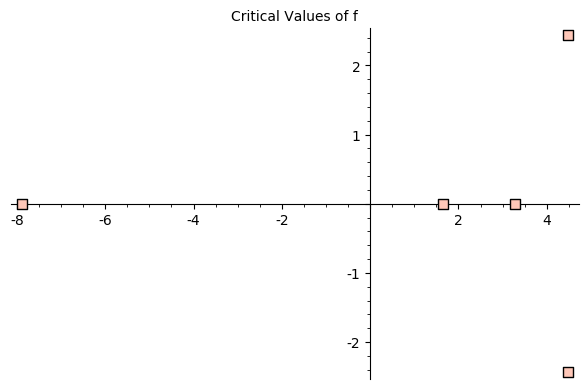

In [34]:
plot_points = [(value.real(), value.imag()) for value in crit_values_f]

scatter_plot(plot_points, marker='s', title="Critical Values of f")

## Determining a matching path

In [35]:
# Choice of regular fibre. In this case, 0 is a regular fibre.


fibre_t = f.get_fibre(t, y)[0].simplify()
fibre_0 = fibre_t.subs(t==0)

In [36]:
# Define the bifibration on a regular fibre

rho = LefschetzFibration([x, y, z, a], fibre_0, 3*x+z)
crit_points_rho = rho.get_critical_points()
crit_values_rho = rho.get_critical_values()

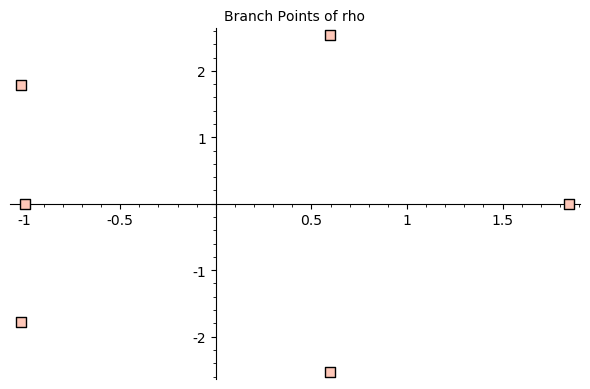

In [37]:
plot_points = [(value.real(), value.imag()) for value in crit_values_rho]
scatter_plot(plot_points, marker='s', title='Branch Points of rho')

In [41]:
matching_critical_value = 2 # Choose the index of the corresponding critical value of f to which we study a matching path

In [42]:
matching_path = {}
for s in np.linspace(0,1,51):
    fibre_s = fibre_t.subs(t==s*crit_values_f[matching_critical_value])
    rho_s = LefschetzFibration([x, y, z, a], fibre_s, rho.fibration)
    matching_path[s] = rho_s.get_critical_values()


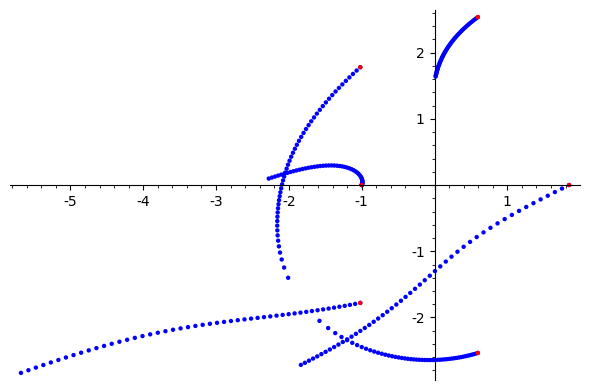

In [43]:
plot_points_highlight = points([(value.real(), value.imag()) for value in matching_path[0]], color='red')

plot_points = points([(value.real(), value.imag()) for crit_values in list(matching_path.values()) for value in crit_values])
plot = plot_points+plot_points_highlight
plot.show()